In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from tensorflow.keras.utils import to_categorical
from scipy.fft import rfft
from statsmodels.tsa.stattools import acf

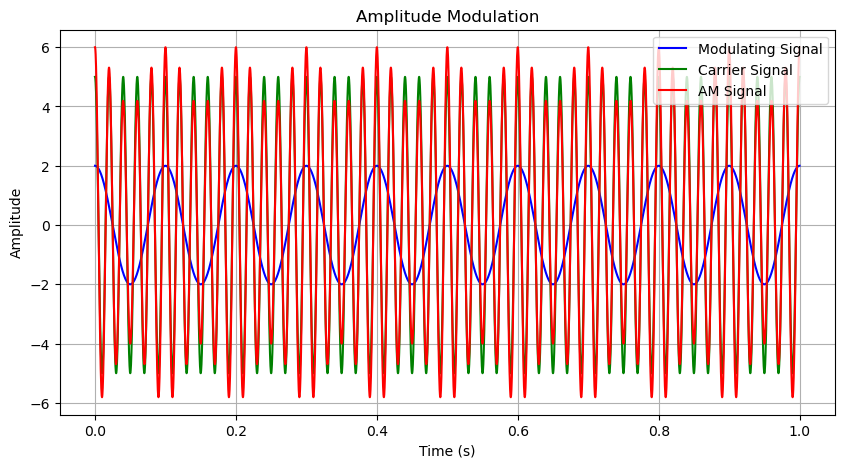

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
fs = 10000  # Sampling frequency (Hz)
fc = 50  # Carrier frequency (Hz)
fm = 10  # Modulating frequency (Hz)
t = np.arange(0, 1, 1/fs)  # Time vector

# --- Modulating signal ---
A = 2.  # Amplitude of the modulating signal
msg = A * np.cos(2 * np.pi * fm * t)

# --- Carrier signal ---
Ac = 5  # Amplitude of the carrier signal
carrier = Ac * np.cos(2 * np.pi * fc * t)

# --- Amplitude Modulation ---
# this is the simulated signal that we want to use
# This is teh QPO signal
am_signal = carrier * (1 + 0.5 * msg / Ac)  # 0.5 is the modulation index

# --- Plotting ---
plt.figure(figsize=(10, 5))
plt.plot(t, msg, label='Modulating Signal', color='blue')
plt.plot(t, carrier, label='Carrier Signal', color='green')
plt.plot(t, am_signal, label='AM Signal', color='red')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude Modulation')
plt.legend()
plt.grid(True)
plt.show()

In [7]:

# --- 1. Simulation Function ---
def simulate_black_hole_lightcurve(fs, fc, fm, qpo_amplitude, duration,
                                   noise_mean=0, noise_std=0.5,
                                   include_qpo=True, modulation_index=0.5):
    """
    Simulate a black hole light curve with stochastic noise and an amplitude-modulated QPO signal.

    Parameters:
        fs : int
            Sampling frequency (Hz)
        fc : float
            Carrier frequency (Hz) for QPO
        fm : float
            Modulating frequency (Hz) for QPO
        qpo_amplitude : float
            Amplitude of the carrier signal (QPO)
        duration : float
            Duration of lightcurve (seconds)
        noise_mean : float
            Mean of the Gaussian noise
        noise_std : float
            Standard deviation of the Gaussian noise
        include_qpo : bool
            Whether to include the QPO signal
        modulation_index : float
            Modulation index for AM signal

    Returns:
        t : np.ndarray
            Time array
        flux : np.ndarray
            Normalized flux array
    """
    # Time array
    t = np.arange(0, duration, 1/fs)

    # White noise
    white_noise = np.random.normal(noise_mean, noise_std, size=len(t))
    white_noise = np.exp(white_noise)

    if include_qpo and qpo_amplitude > 0:
        # Modulating signal
        msg = qpo_amplitude * np.cos(2 * np.pi * fm * t)

        # Carrier signal
        carrier = qpo_amplitude * np.cos(2 * np.pi * fc * t)

        # AM QPO signal
        qpo = carrier * (1 + modulation_index * msg / qpo_amplitude)
    else:
        qpo = 0

    # Combine noise and QPO signal
    flux = white_noise + qpo

    # Normalize
    flux = (flux - np.mean(flux)) / np.std(flux)

    return t, flux

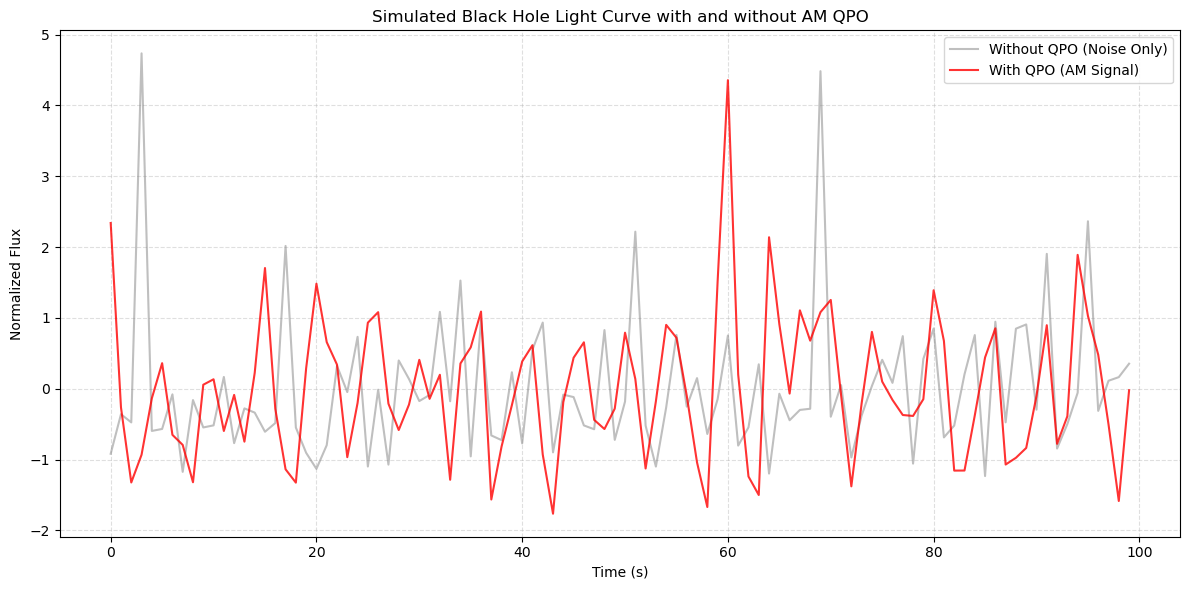

In [4]:
# --- Simulation Parameters ---
fs = 1           # Sampling frequency (Hz)
fc = 0.2             # QPO (carrier) frequency in Hz
fm = 0.05            # Modulating frequency in Hz
duration = 100        # Duration of the signal in seconds
qpo_amplitude = 0.6 # Amplitude of QPO signal

# --- Generate Simulated Light Curves ---
t, flux_with_qpo = simulate_black_hole_lightcurve(
    fs, fc, fm, qpo_amplitude=qpo_amplitude, duration=duration, include_qpo=True)

_, flux_without_qpo = simulate_black_hole_lightcurve(
    fs, fc, fm, qpo_amplitude=qpo_amplitude, duration=duration, include_qpo=False)

# --- Plotting the Time-Domain Light Curve ---
plt.figure(figsize=(12, 6))
plt.plot(t, flux_without_qpo, color='gray', alpha=0.5, label="Without QPO (Noise Only)")
plt.plot(t, flux_with_qpo, color='red', alpha=0.8, label="With QPO (AM Signal)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Flux")
plt.title("Simulated Black Hole Light Curve with and without AM QPO")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


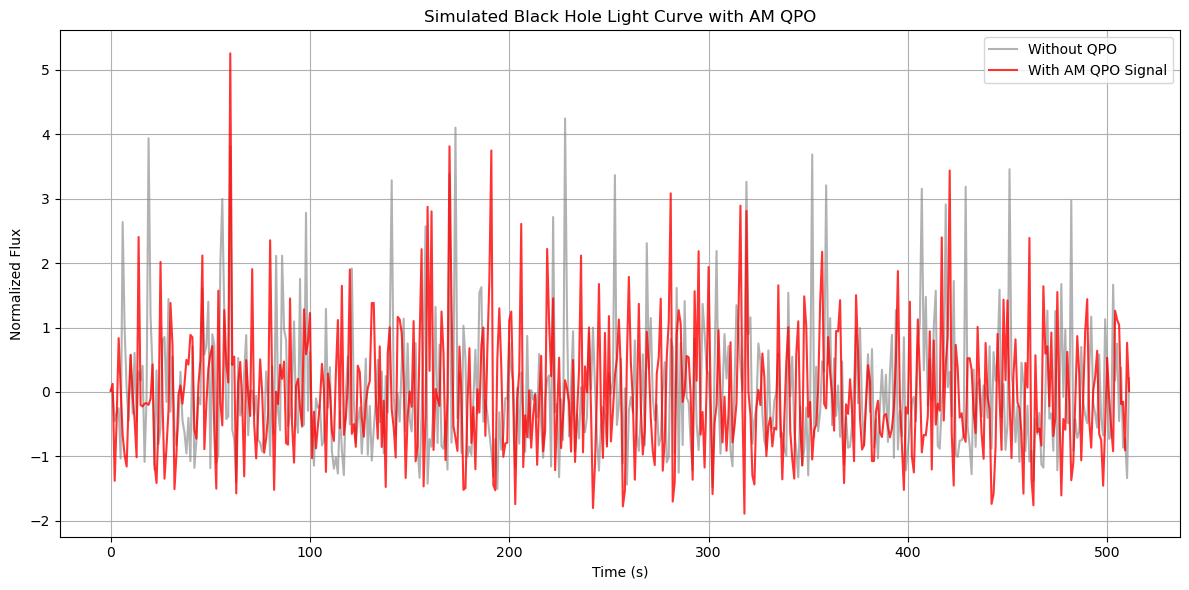

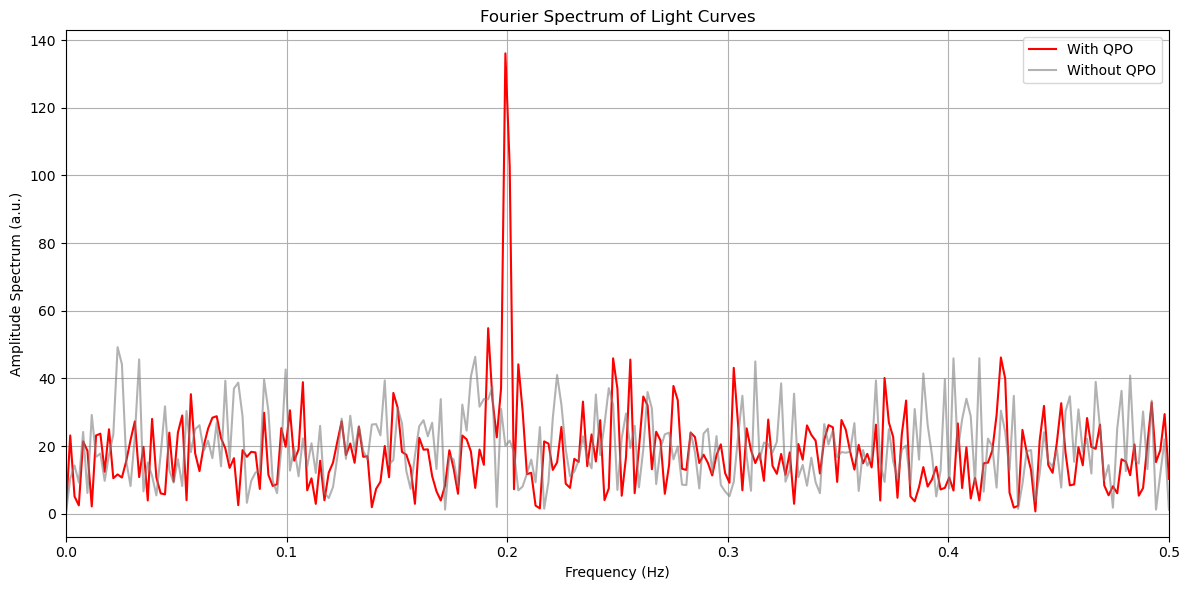

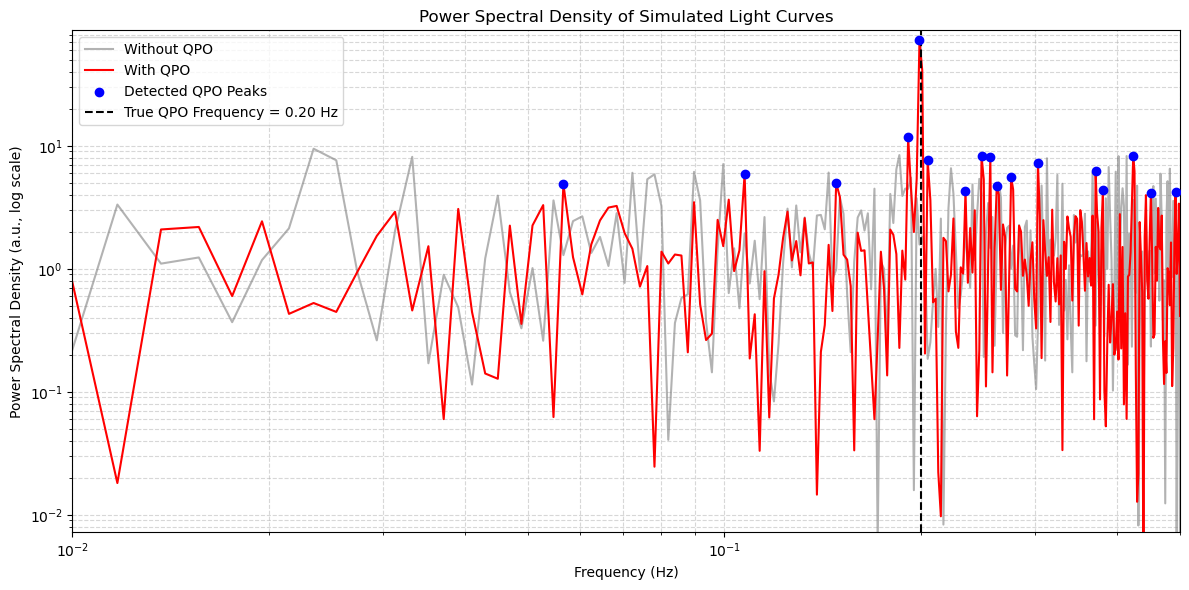

In [5]:
# --- Simulate a QPO and non-QPO light curve ---
fs = 1      # Sampling frequency (Hz)
duration = 512    # Duration in seconds
fc = 0.2         # QPO (carrier) frequency
fm = 0.05        # Modulation frequency
amplitude = 0.4  # QPO signal amplitude

# Generate signals
t, flux_with_qpo = simulate_black_hole_lightcurve(
    fs, fc, fm, amplitude, duration, include_qpo=True)
_, flux_without_qpo = simulate_black_hole_lightcurve(
    fs, fc, fm, amplitude, duration, include_qpo=False)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t, flux_without_qpo, color='gray', alpha=0.6, label="Without QPO")
plt.plot(t, flux_with_qpo, color='red', alpha=0.8, label="With AM QPO Signal")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Flux")
plt.title("Simulated Black Hole Light Curve with AM QPO")
# plt.xlim(0, 2)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Fourier Transform ---
n = len(t)
freqs = np.fft.rfftfreq(n, 1/fs)

fft_qpo = np.abs(np.fft.rfft(flux_with_qpo))
fft_non_qpo = np.abs(np.fft.rfft(flux_without_qpo))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(freqs, fft_qpo, label="With QPO", color='red')
plt.plot(freqs, fft_non_qpo, label="Without QPO", color='gray', alpha=0.6)
plt.xlim(0, 0.5)  # focus on QPO frequency range
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude Spectrum (a.u.)")
plt.title("Fourier Spectrum of Light Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

N = len(flux_with_qpo)

# Periodogram (Power Spectrum)
periodogram_with_qpo = (2.0 / N) * np.abs(fft_qpo)**2
periodogram_without_qpo = (2.0 / N) * np.abs(fft_non_qpo)**2

# --- Peak Detection ---
peaks, _ = find_peaks(periodogram_with_qpo,
                      height=np.mean(periodogram_with_qpo)*2)

# --- Plot Periodogram with Detected Peaks ---
plt.figure(figsize=(12, 6))
plt.plot(freqs, periodogram_without_qpo,
         color='gray', alpha=0.6, label="Without QPO")
plt.plot(freqs, periodogram_with_qpo, color='red', label="With QPO")
plt.scatter(freqs[peaks], periodogram_with_qpo[peaks],
            color='blue', zorder=5, label="Detected QPO Peaks")
plt.axvline(fc, color='black', linestyle='--',
            label=f"True QPO Frequency = {fc:.2f} Hz")

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01, 0.5)
max_power = np.max(periodogram_with_qpo)
plt.ylim(max_power * 1e-4, max_power * 1.2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (a.u., log scale)")
plt.title("Power Spectral Density of Simulated Light Curves")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf


def verify_qpo_simulation(t, flux, qpo_freq_expected=None, fs=1.0):
    """
    Verify the presence of a QPO in a simulated light curve using:
    1. Fourier Power Spectrum (rFFT-based Periodogram)
    2. Autocorrelation Function (ACF)

    Parameters:
    - t: Time array
    - flux: Simulated light curve
    - qpo_freq_expected: Expected QPO frequency for reference (optional)
    - fs: Sampling frequency (Hz)
    """
    N = len(flux)
    T = 1.0 / fs

    # rFFT and frequency axis
    fft_vals = np.fft.rfft(flux)
    freqs = np.fft.rfftfreq(N, T)

    # Periodogram (PSD)
    power = (2.0 / N) * np.abs(fft_vals)**2

    # Detect peaks in PSD
    peaks, props = find_peaks(power, height=np.mean(power) * 2)

    # Autocorrelation Function
    lag_values = np.arange(0, 200)
    acf_vals = acf(flux, nlags=199, fft=True)

    # --- Plot PSD and ACF ---
    plt.figure(figsize=(12, 6))

    # PSD
    plt.subplot(2, 1, 1)
    plt.plot(freqs, power, label="Power Spectrum", color='darkblue')
    plt.scatter(freqs[peaks], power[peaks],
                color='red', label="Detected Peaks")
    if qpo_freq_expected:
        plt.axvline(qpo_freq_expected, linestyle='--', color='black',
                    label=f"Expected QPO = {qpo_freq_expected:.2f} Hz")

    plt.xscale("log")
    plt.yscale("log")
    max_power = np.max(power)
    plt.ylim(max_power * 1e-4, max_power * 1.2)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (log scale)")
    plt.title("Fourier Periodogram for QPO Detection")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()

    # ACF
    plt.subplot(2, 1, 2)
    plt.plot(lag_values, acf_vals, color='green', label="ACF")
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Lag (Time Steps)")
    plt.ylabel("Autocorrelation")
    plt.title("Autocorrelation Function (ACF) of Light Curve")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- Print Summary ---
    print("🔍 Detected QPO frequency peaks (Hz):", freqs[peaks])

    if qpo_freq_expected:
        close_peaks = [f for f in freqs[peaks]
                       if np.isclose(f, qpo_freq_expected, atol=0.02)]
        if close_peaks:
            print(
                f"✔ QPO detected near {qpo_freq_expected:.2f} Hz:", close_peaks)
        else:
            print(
                f"❌ No significant QPO detected near {qpo_freq_expected:.2f} Hz.")

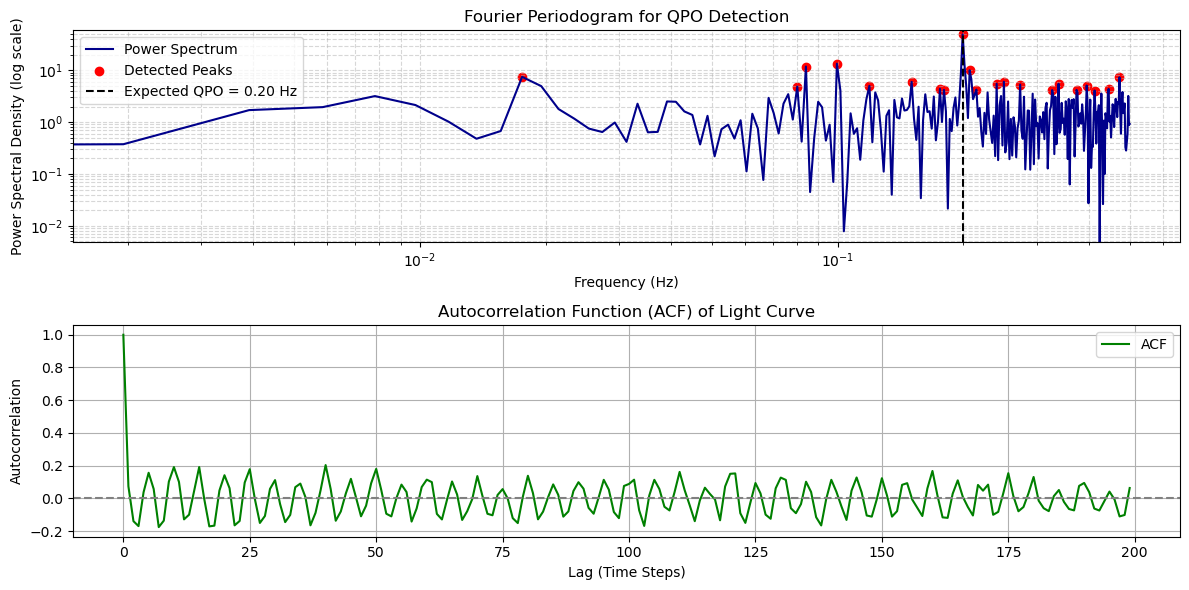

🔍 Detected QPO frequency peaks (Hz): [0.01757812 0.08007812 0.08398438 0.09960938 0.11914062 0.15039062
 0.17578125 0.1796875  0.19921875 0.20703125 0.21484375 0.24023438
 0.25       0.2734375  0.32617188 0.33789062 0.37304688 0.39453125
 0.41210938 0.4453125  0.47265625]
✔ QPO detected near 0.20 Hz: [0.19921875, 0.20703125, 0.21484375]


In [7]:
# Simulate light curve with QPO
fs = 1
duration = 512
fc = 0.2  # QPO frequency
fm = 0.05
amplitude = 0.4

t, flux_with_qpo = simulate_black_hole_lightcurve(fs, fc, fm, amplitude, duration, include_qpo=True)

# Verify QPO presence
verify_qpo_simulation(t, flux_with_qpo, qpo_freq_expected=fc, fs=fs)


In [8]:
def generate_dataset_for_amplitude(amp, output_dir, num_samples=5000, fs=1, duration=512, modulation_index=0.5):
    os.makedirs(output_dir, exist_ok=True)

    seq_length = int(duration * fs)
    dataset = []
    labels = []

    for _ in range(num_samples // 2):

        fc = np.random.uniform(0.01, 1.0)
        fm = np.random.uniform(0.005, 0.1)

        t, flux_qpo = simulate_black_hole_lightcurve(
            fs, fc, fm, amp, duration, include_qpo=True, modulation_index=modulation_index)
        _, flux_non_qpo = simulate_black_hole_lightcurve(
            fs, fc, fm, amp, duration, include_qpo=False, modulation_index=modulation_index)

        dataset.append(flux_qpo[:seq_length].reshape(-1, 1))
        labels.append(1)

        dataset.append(flux_non_qpo[:seq_length].reshape(-1, 1))
        labels.append(0)

    dataset = np.array(dataset)
    labels = to_categorical(np.array(labels), 2)

    np.savez_compressed(os.path.join(
        output_dir, 'data.npz'), X=dataset, y=labels)

In [9]:
amp = 0.2
folder = f"qpo_experiments/dataset_amp_{amp}"
generate_dataset_for_amplitude(amp, folder)

Dataset shape: (5000, 512, 1)
Labels shape: (5000, 2)


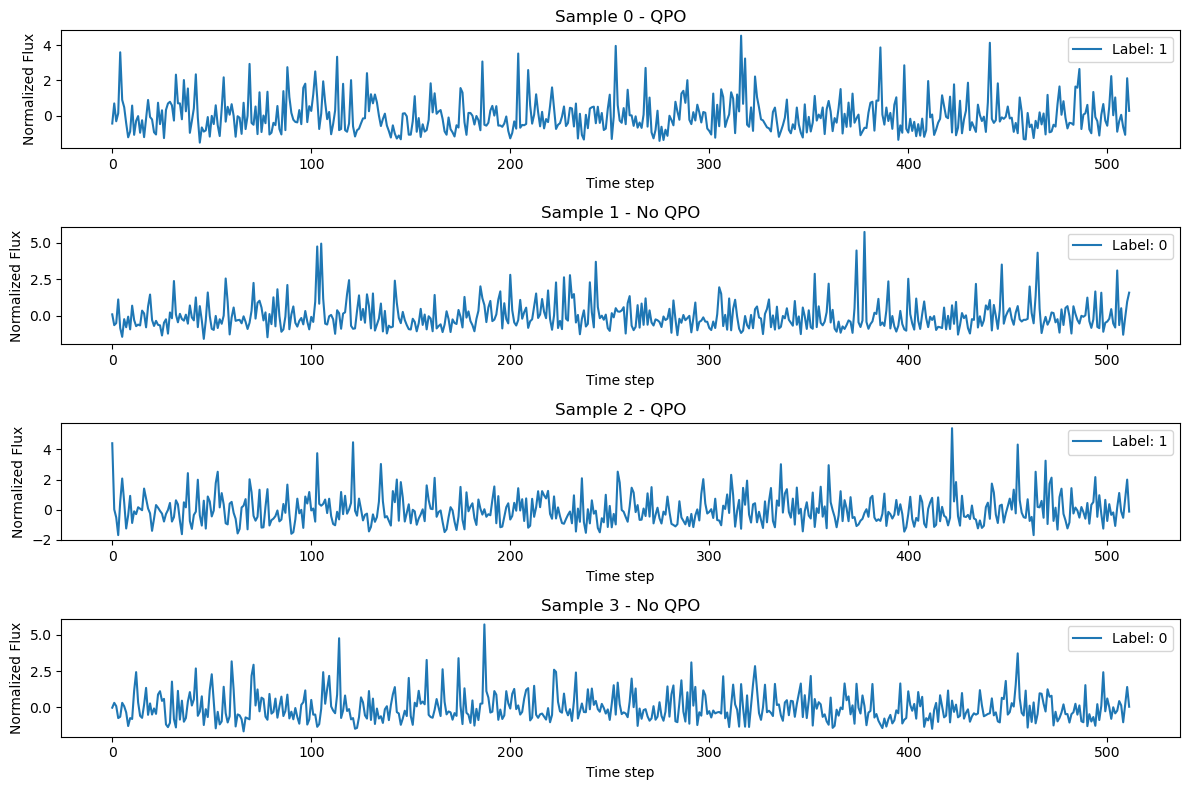

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Load your .npz file
data = np.load('qpo_experiments/dataset_amp_0.2/data.npz')
X = data['X']  # Shape: (samples, time_steps, 1)
y = data['y']  # Shape: (samples, 2)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

# Plot a few samples
num_samples_to_plot = 4

plt.figure(figsize=(12, 8))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(X[i].squeeze(), label=f"Label: {np.argmax(y[i])}")
    plt.title(f"Sample {i} - {'QPO' if np.argmax(y[i]) == 1 else 'No QPO'}")
    plt.xlabel("Time step")
    plt.ylabel("Normalized Flux")
    plt.legend()
    plt.tight_layout()

plt.show()


In [12]:
amplitudes = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for amp in amplitudes:
    print(f"\n🚀 Generating Data on amplitude: {amp}")
    folder = f"qpo_experiments/dataset_amp_{amp}"
    generate_dataset_for_amplitude(amp, folder)


🚀 Generating Data on amplitude: 0.0

🚀 Generating Data on amplitude: 0.2

🚀 Generating Data on amplitude: 0.4

🚀 Generating Data on amplitude: 0.6

🚀 Generating Data on amplitude: 0.8

🚀 Generating Data on amplitude: 1.0


<!-- Dataset generation with acf and power spectrum -->

In [4]:
def compute_acf(flux, nlags=None):
    """Compute Autocorrelation Function using FFT."""
    if nlags is None:
        nlags = len(flux) - 1
    return acf(flux, nlags=nlags, fft=True)


def compute_power_spectrum(flux, target_len=None):
    """Compute Power Spectrum using rFFT."""
    n = len(flux)
    fft_vals = rfft(flux)
    psd = (2.0 / n) * np.abs(fft_vals)**2
    if target_len is not None and len(psd) < target_len:
        psd = np.pad(psd, (0, target_len - len(psd)), mode='constant')
    return psd


def normalize_flux(x):
    return (x - np.mean(x)) / np.std(x)


def normalize_feature(x):
    return (x - np.mean(x)) / np.std(x) if np.std(x) > 0 else x


def generate_feature_enriched_dataset_for_amplitude(amp, output_dir, num_samples=5000, fs=1, duration=512, modulation_index=0.5):
    """
    Generate dataset with flux, ACF, and Power Spectrum as 3 input channels.
    """
    os.makedirs(output_dir, exist_ok=True)

    seq_length = int(duration * fs)
    dataset = []
    labels = []

    for _ in range(num_samples // 2):
        # Random QPO properties
        fc = np.random.uniform(0.01, 1.0)
        fm = np.random.uniform(0.005, 0.1)

        # --- QPO Sample ---
        t, flux_qpo = simulate_black_hole_lightcurve(
            fs, fc, fm, amp, duration, include_qpo=True, modulation_index=modulation_index)
        flux_qpo = normalize_flux(flux_qpo)
        acf_qpo = normalize_feature(
            compute_acf(flux_qpo, nlags=seq_length - 1))
        psd_qpo = normalize_feature(
            compute_power_spectrum(flux_qpo, target_len=seq_length))

        sample_qpo = np.column_stack((flux_qpo, acf_qpo, psd_qpo))
        dataset.append(sample_qpo[:seq_length])
        labels.append(1)

        # --- Non-QPO Sample ---
        _, flux_non_qpo = simulate_black_hole_lightcurve(
            fs, fc, fm, amp, duration, include_qpo=False, modulation_index=modulation_index)
        flux_non_qpo = normalize_flux(flux_non_qpo)
        acf_non_qpo = normalize_feature(
            compute_acf(flux_non_qpo, nlags=seq_length - 1))
        psd_non_qpo = normalize_feature(compute_power_spectrum(
            flux_non_qpo, target_len=seq_length))

        sample_non_qpo = np.column_stack(
            (flux_non_qpo, acf_non_qpo, psd_non_qpo))
        dataset.append(sample_non_qpo[:seq_length])
        labels.append(0)

    dataset = np.array(dataset)  # Shape: (num_samples, 512, 3)
    labels = to_categorical(np.array(labels), 2)

    # Save compressed dataset
    np.savez_compressed(os.path.join(
        output_dir, f'dataset_amp_{amp:.2f}.npz'), X=dataset, y=labels)
    print(f"✔ Dataset saved to {output_dir}, shape = {dataset.shape}")

In [8]:
generate_feature_enriched_dataset_for_amplitude(
    amp=0.6,
    output_dir="qpo_dataset_features",
    num_samples=1000,
    fs=1,
    duration=512,
    modulation_index=0.5
)

✔ Dataset saved to qpo_dataset_features, shape = (1000, 512, 3)


Dataset shape: (1000, 512, 3)
Labels shape: (1000, 2)


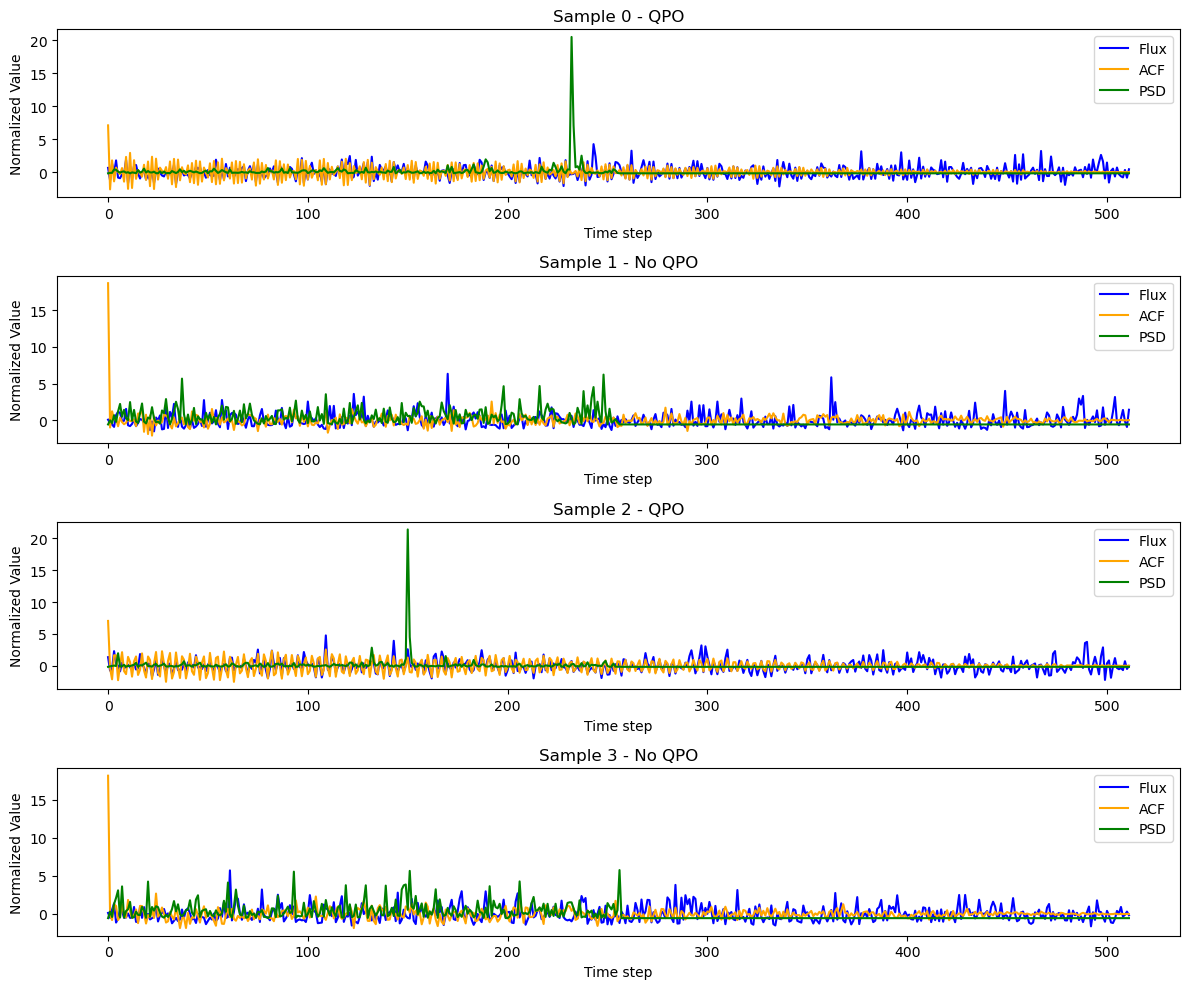

In [9]:

# Load your .npz file
data = np.load('qpo_dataset_features/dataset_amp_0.60.npz')
X = data['X']  # Shape: (samples, time_steps, 1)
y = data['y']  # Shape: (samples, 2)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

# Plot a few samples
num_samples_to_plot = 4

feature_names = ["Flux", "ACF", "PSD"]
colors = ["blue", "orange", "green"]

plt.figure(figsize=(12, 10))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    
    for j in range(3):  # 3 channels: flux, acf, psd
        plt.plot(X[i, :, j], label=f"{feature_names[j]}", color=colors[j])
    label_text = 'QPO' if np.argmax(y[i]) == 1 else 'No QPO'
    plt.title(f"Sample {i} - {label_text}")
    plt.xlabel("Time step")
    plt.ylabel("Normalized Value")
    plt.legend()
    plt.tight_layout()

plt.show()


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def plot_avg_acf_vs_nonqpo(X, y, acf_channel=1, fs=1.0, max_lag=150, height=0.02, distance=10):
    """
    Plot average ACF for QPO and non-QPO samples, and estimate QPO frequency.

    Parameters:
    - X: dataset of shape (samples, timesteps, channels)
    - y: one-hot encoded labels (samples, 2)
    - acf_channel: index of the ACF channel in X
    - fs: sampling frequency (Hz)
    - max_lag: maximum lag to display
    - height: peak height threshold for detecting ACF peaks
    - distance: minimum distance between peaks (in lags)
    """

    acf_qpo_all = []
    acf_nonqpo_all = []

    for i in range(len(X)):
        acf = X[i, :, acf_channel]
        # Normalize each ACF individually (lag 0 = 1)
        # acf = acf / acf[0] if acf[0] != 0 else acf
        if np.argmax(y[i]) == 1:
            acf_qpo_all.append(acf)
        else:
            acf_nonqpo_all.append(acf)

    mean_acf_qpo = np.mean(acf_qpo_all, axis=0)
    mean_acf_nonqpo = np.mean(acf_nonqpo_all, axis=0)

    # Estimate QPO frequency from ACF peaks
    peaks, _ = find_peaks(mean_acf_qpo[:max_lag], height=height, distance=distance)
    estimated_periods = np.diff(peaks)
    if len(estimated_periods) > 0:
        avg_period = np.mean(estimated_periods)
        qpo_freq = fs / avg_period
        print(f"📡 Estimated QPO Frequency: {qpo_freq:.4f} Hz (from ACF peak spacing)")
    else:
        print("⚠️ No significant peaks found in ACF for QPO frequency estimation.")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(mean_acf_qpo[:max_lag], label="Avg ACF - QPO", color='orange')
    plt.plot(mean_acf_nonqpo[:max_lag], label="Avg ACF - Non-QPO", color='gray')
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title("Average ACF (QPO vs Non-QPO, Normalized)")
    plt.ylim(-0.2, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


📡 Estimated QPO Frequency: 0.0763 Hz (from ACF peak spacing)


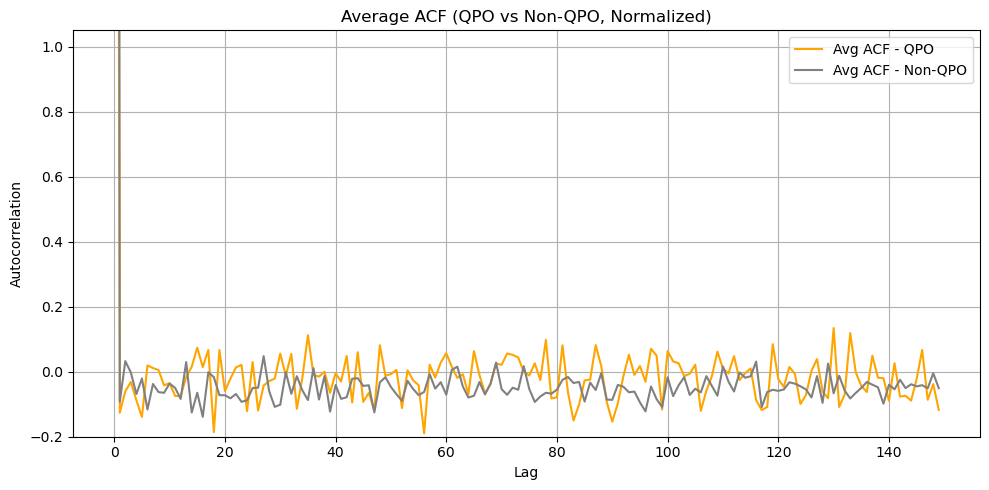

In [37]:
plot_avg_acf_vs_nonqpo(X, y, acf_channel=1, fs=1.0, max_lag=150)


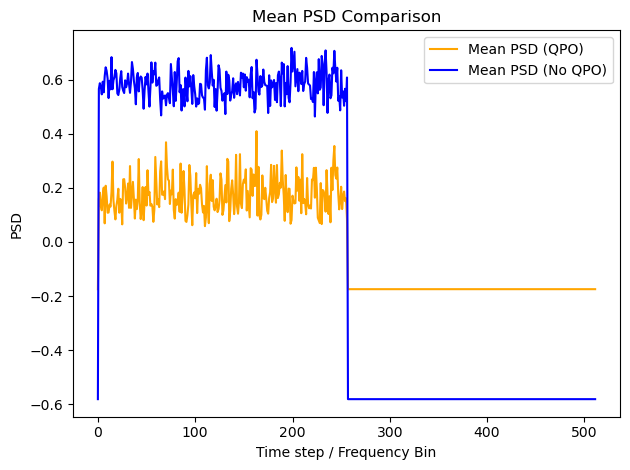

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Identify QPO and No QPO samples
qpo_indices = np.where(np.argmax(y, axis=1) == 1)[0]
no_qpo_indices = np.where(np.argmax(y, axis=1) == 0)[0]

# ACF is channel 1, PSD is channel 2 if we follow your indexing in the plot code
acf_channel = 1
psd_channel = 2


# Compute mean PSD for QPO and No QPO
mean_psd_qpo = np.mean(X[qpo_indices, :, psd_channel], axis=0)
mean_psd_no_qpo = np.mean(X[no_qpo_indices, :, psd_channel], axis=0)


# --- Plot Mean PSD ---
plt.plot(mean_psd_qpo, label='Mean PSD (QPO)', color='orange')
plt.plot(mean_psd_no_qpo, label='Mean PSD (No QPO)', color='blue')
plt.title('Mean PSD Comparison')
plt.xlabel('Time step / Frequency Bin')
plt.ylabel('PSD')
plt.legend()

plt.tight_layout()
plt.show()


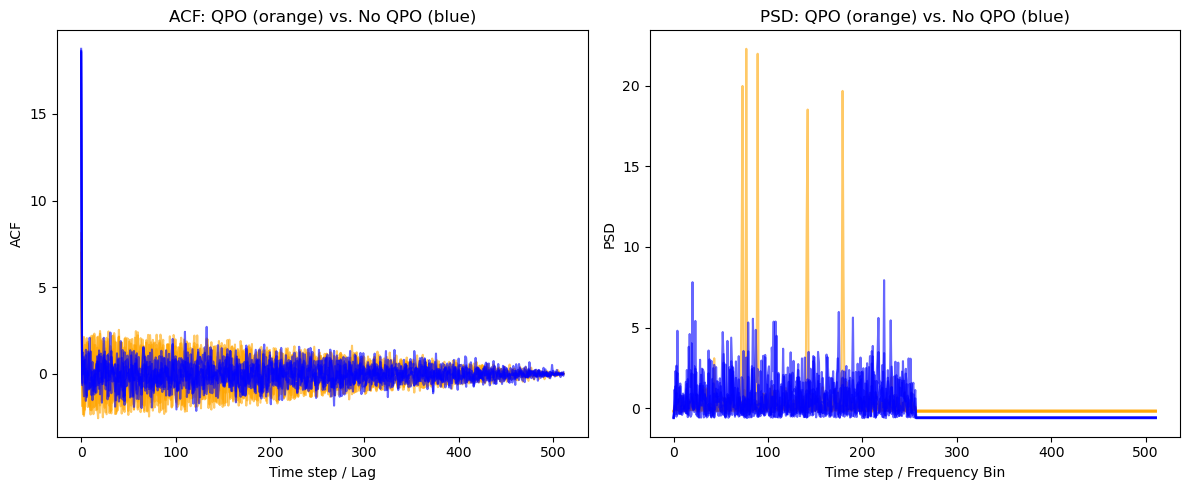

In [39]:
import random

# Randomly select a few QPO and No QPO samples
n_examples = 5
random_qpo = random.sample(list(qpo_indices), n_examples)
random_no_qpo = random.sample(list(no_qpo_indices), n_examples)

plt.figure(figsize=(12, 5))

# --- ACF Plots ---
plt.subplot(1, 2, 1)
for idx in random_qpo:
    plt.plot(X[idx, :, acf_channel], alpha=0.6, color='orange')
for idx in random_no_qpo:
    plt.plot(X[idx, :, acf_channel], alpha=0.6, color='blue')
plt.title('ACF: QPO (orange) vs. No QPO (blue)')
plt.xlabel('Time step / Lag')
plt.ylabel('ACF')

# --- PSD Plots ---
plt.subplot(1, 2, 2)
for idx in random_qpo:
    plt.plot(X[idx, :, psd_channel], alpha=0.6, color='orange')
for idx in random_no_qpo:
    plt.plot(X[idx, :, psd_channel], alpha=0.6, color='blue')
plt.title('PSD: QPO (orange) vs. No QPO (blue)')
plt.xlabel('Time step / Frequency Bin')
plt.ylabel('PSD')

plt.tight_layout()
plt.show()


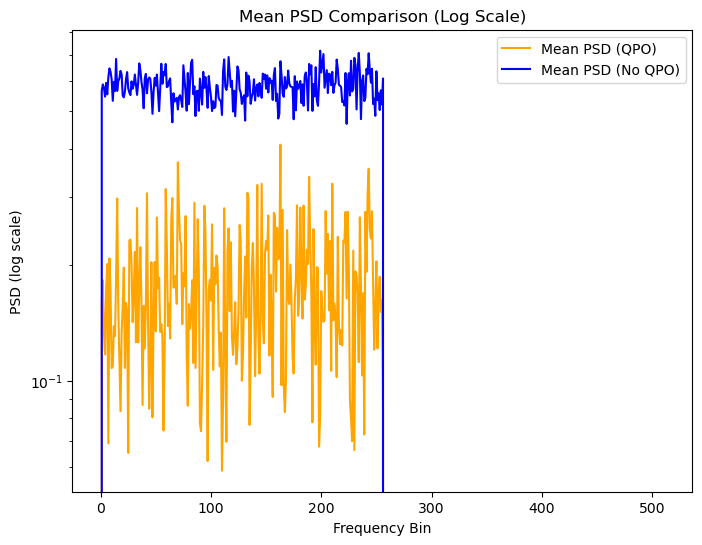

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(mean_psd_qpo, label='Mean PSD (QPO)', color='orange')
plt.plot(mean_psd_no_qpo, label='Mean PSD (No QPO)', color='blue')
plt.yscale('log')  # Log scale for the y-axis
plt.title('Mean PSD Comparison (Log Scale)')
plt.xlabel('Frequency Bin')
plt.ylabel('PSD (log scale)')
plt.legend()
plt.show()


/var/folders/15/7vdcd9756072lbp614rqt18c0000gn/T/ipykernel_20327/2162911143.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([max_psd_qpo, max_psd_no_qpo], labels=['QPO','No QPO'])


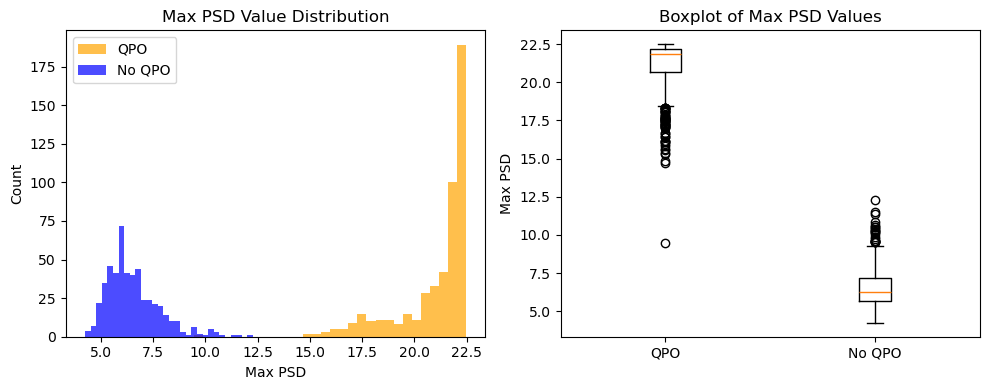

In [41]:
# Example: Extract the max PSD value for each sample
max_psd_values = np.max(X[:, :, psd_channel], axis=1)

max_psd_qpo = max_psd_values[qpo_indices]
max_psd_no_qpo = max_psd_values[no_qpo_indices]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(max_psd_qpo, bins=30, alpha=0.7, label='QPO', color='orange')
plt.hist(max_psd_no_qpo, bins=30, alpha=0.7, label='No QPO', color='blue')
plt.title('Max PSD Value Distribution')
plt.xlabel('Max PSD')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot([max_psd_qpo, max_psd_no_qpo], labels=['QPO','No QPO'])
plt.ylabel('Max PSD')
plt.title('Boxplot of Max PSD Values')

plt.tight_layout()
plt.show()


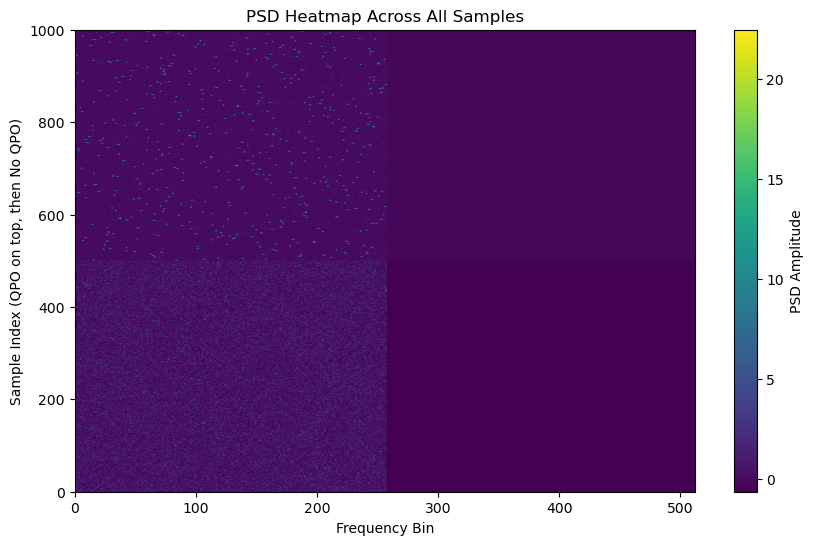

In [42]:
plt.figure(figsize=(10, 6))

# Sort the samples by label just for clarity (QPO first, then No QPO)
sorted_indices = np.concatenate([qpo_indices, no_qpo_indices])
sorted_psd = X[sorted_indices, :, psd_channel]

plt.imshow(sorted_psd, aspect='auto', cmap='viridis',
           extent=[0, sorted_psd.shape[1], 0, sorted_psd.shape[0]])
plt.colorbar(label='PSD Amplitude')
plt.xlabel('Frequency Bin')
plt.ylabel('Sample Index (QPO on top, then No QPO)')
plt.title('PSD Heatmap Across All Samples')
plt.show()


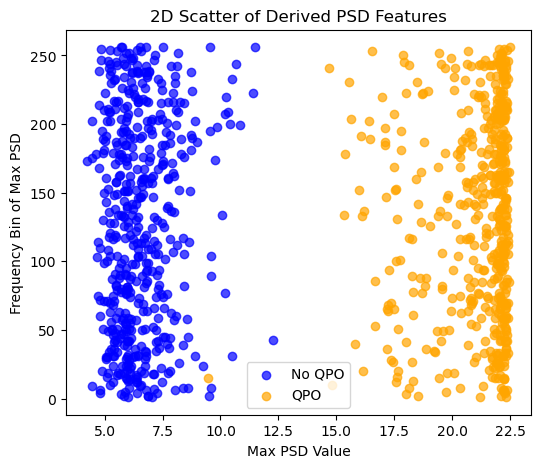

In [43]:
# Example features:
#   f1 = max PSD
#   f2 = frequency bin of max PSD
psd_data = X[:, :, psd_channel]
f1 = np.max(psd_data, axis=1)
f2 = np.argmax(psd_data, axis=1)

qpo_mask = (np.argmax(y, axis=1) == 1)

plt.figure(figsize=(6, 5))
plt.scatter(f1[~qpo_mask], f2[~qpo_mask], alpha=0.7, label='No QPO', color='blue')
plt.scatter(f1[qpo_mask], f2[qpo_mask], alpha=0.7, label='QPO', color='orange')
plt.xlabel('Max PSD Value')
plt.ylabel('Frequency Bin of Max PSD')
plt.title('2D Scatter of Derived PSD Features')
plt.legend()
plt.show()
